# PreProcessing

In [2]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
import matplotlib.pyplot as plt

D:\AnacondaEditor\envs\TumorSegmentation\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'D:\AnacondaEditor\envs\TumorSegmentation\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
in_dir='D:/LungData/Final_data'
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainLabels", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestLabels", "*.nii.gz")))

In [4]:
train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

In [5]:
    pixdim=(1.5, 1.5, 1.0)
    a_min=-200
    a_max=200
    spatial_size=[128,128,180]
    cache=True

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)



D:\AnacondaEditor\envs\TumorSegmentation\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
D:\AnacondaEditor\envs\TumorSegmentation\lib\site-packages\monai\utils\deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
D:\AnacondaEditor\envs\TumorSegmentation\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys`

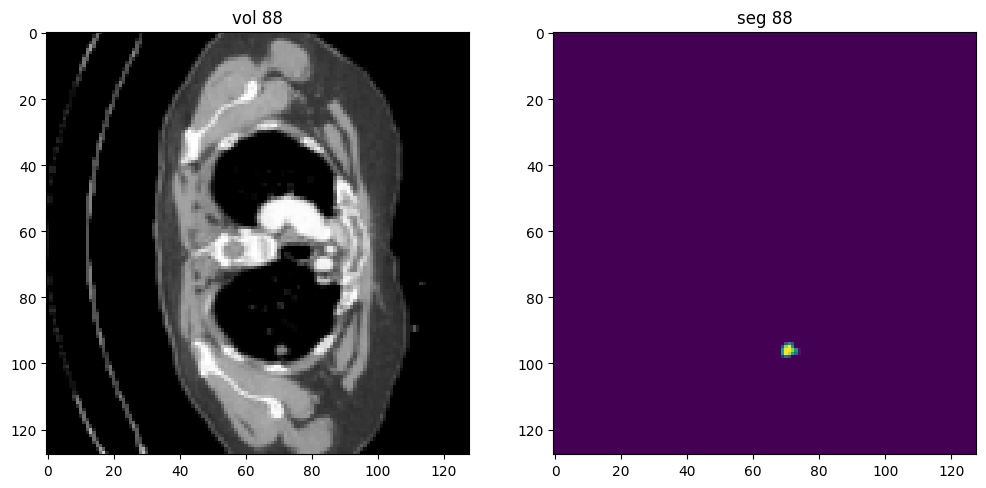

In [8]:
    SLICE_NUMBER=88
    train=True
    test=False
    check_patient_train=train_loader
    check_patient_test=test_loader

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
